In [33]:
import glob, h5py, os, re, sys, time
from itertools import product
from pathlib import Path
from filelock import FileLock

import matplotlib.pyplot as plt
import logomaker
import tfomics
import numpy as np
import pandas as pd
from multiprocess import Pool
from tqdm.notebook import tqdm
from scipy.special import softmax, kl_div, rel_entr
from scipy.stats import pearsonr
from six.moves import cPickle
from tqdm import tqdm

from acme.kmer import kmer_featurization
from acme import interval
from acme import utils

In [2]:
BASE_DIR = Path.cwd().parent
evaluation_path = BASE_DIR.joinpath("data/atac/atac_model_pearson.csv")

DATA_DIR = BASE_DIR.joinpath("data/atac/cell_line_testsets")
saliency_subset_dir = BASE_DIR.joinpath("data/atac/saliency_subset")

# cell line paths
cell_line_dict = {
    "A549": f"{DATA_DIR}/cell_line_8.h5",
    "HCT116": f"{DATA_DIR}/cell_line_9.h5",
    "GM12878": f"{DATA_DIR}/cell_line_7.h5",
    "K562": f"{DATA_DIR}/cell_line_5.h5",
    "PC-3": f"{DATA_DIR}/cell_line_13.h5",
    "HepG2": f"{DATA_DIR}/cell_line_2.h5"
}

In [3]:
# Local prior entropy 
def ortonormal_coordinates(attr_map):
    """reduce 4d array to 3d"""

    attr_map_on = np.zeros((attr_map.shape[0], attr_map.shape[1], 3))

    x = attr_map[:, :, 0]
    y = attr_map[:, :, 1]
    z = attr_map[:, :, 2]
    w = attr_map[:, :, 3]

    # Now convert to new coordinates
    e1 = 1 / np.sqrt(2) * (-x + y)
    e2 = np.sqrt(2 / 3) * (-1/2*x -1/2*y)
    e3 = np.sqrt(3 / 4) * (-1/3*x -1/3*y -1/3*z + w)
    attr_map_on[:, :, 0] = e1
    attr_map_on[:, :, 1] = e2
    attr_map_on[:, :, 2] = e3

    return attr_map_on

def process_attribution_map(saliency_map_raw):
    saliency_map_raw = saliency_map_raw - np.mean(saliency_map_raw, axis=-1, keepdims=True) #gradient correction
    saliency_map_raw = saliency_map_raw / np.sum(np.sqrt(np.sum(np.square(saliency_map_raw), axis=-1, keepdims=True)), axis=-2, keepdims=True) #normalize
    saliency_map_raw_rolled = np.roll(saliency_map_raw, -1, axis=-2)
    saliency_map_raw_rolled_twice = np.roll(saliency_map_raw, -2, axis=-2)
    saliency_map_raw_rolled_triple = np.roll(saliency_map_raw, -3, axis=-2)
    saliency_map_raw_rolled_4 = np.roll(saliency_map_raw, -4, axis=-2)
    saliency_map_raw_rolled_5 = np.roll(saliency_map_raw, -5, axis=-2)
    saliency_map_raw_rolled_6 = np.roll(saliency_map_raw, -6, axis=-2)
    # Define k-window here, include k terms below (here k = 3)
    saliency_special = saliency_map_raw + saliency_map_raw_rolled + saliency_map_raw_rolled_twice #+ saliency_map_raw_rolled_triple # + saliency_map_raw_rolled_4 + saliency_map_raw_rolled_5 #This line is optional.
    saliency_special = ortonormal_coordinates(saliency_special) #Down to 3D, since data lives on the plane.
    return saliency_special

def spherical_coordinates_process_2_trad(saliency_map_raw_s, X, mask, radius_count_cutoff=0.04):   # r_squared_weighted
    global N_EXP
    N_EXP = len(saliency_map_raw_s)
    radius_count=int(radius_count_cutoff * np.prod(X.shape)/4)
    cutoff=[]
    x_s, y_s, z_s, r_s, phi_1_s, phi_2_s = [], [], [], [], [], []
    for s in range (0, N_EXP):
        saliency_map_raw = saliency_map_raw_s[s]
        xxx_motif=saliency_map_raw[:,:,0]
        yyy_motif=(saliency_map_raw[:,:,1])
        zzz_motif=(saliency_map_raw[:,:,2])
        xxx_motif_pattern=saliency_map_raw[:,:,0]*mask
        yyy_motif_pattern=(saliency_map_raw[:,:,1])*mask
        zzz_motif_pattern=(saliency_map_raw[:,:,2])*mask
        r=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
        resh = X.shape[0] * X.shape[1]
        x=np.array(xxx_motif_pattern.reshape(resh,))
        y=np.array(yyy_motif_pattern.reshape(resh,))
        z=np.array(zzz_motif_pattern.reshape(resh,))
        r=np.array(r.reshape(resh,))
        #Take care of any NANs.
        x=np.nan_to_num(x)
        y=np.nan_to_num(y)
        z=np.nan_to_num(z)
        r=np.nan_to_num(r)
        cutoff.append( np.sort(r)[-radius_count] )
        R_cuttof_index = np.sqrt(x*x+y*y+z*z) > cutoff[s]
        #Cut off
        x=x[R_cuttof_index]
        y=y[R_cuttof_index]
        z=z[R_cuttof_index]
        r=np.array(r[R_cuttof_index])
        x_s.append(x)
        y_s.append(y)
        z_s.append(z)
        r_s.append(r)
        #rotate axis
        x__ = np.array(y)
        y__ = np.array(z)
        z__ = np.array(x)
        x = x__
        y = y__
        z = z__
        #"phi"
        phi_1 = np.arctan(y/x) #default
        phi_1 = np.where((x<0) & (y>=0), np.arctan(y/x) + PI, phi_1)   #overwrite
        phi_1 = np.where((x<0) & (y<0), np.arctan(y/x) - PI, phi_1)   #overwrite
        phi_1 = np.where (x==0, PI/2, phi_1) #overwrite
        #Renormalize temorarily to have both angles in [0,PI]:
        phi_1 = phi_1/2 + PI/2
        #"theta"
        phi_2=np.arccos(z/r)
        #back to list
        phi_1 = list(phi_1)
        phi_2 = list(phi_2)
        phi_1_s.append(phi_1)
        phi_2_s.append(phi_2)
    #print(cutoff)
    return phi_1_s, phi_2_s, r_s
def initialize_integration_2(box_length):
    LIM = 3.1416
    global volume_border_correction
    box_volume = box_length*box_length
    n_bins = int(LIM/box_length)
    volume_border_correction =  (LIM/box_length/n_bins)*(LIM/box_length/n_bins)
    #print('volume_border_correction = ', volume_border_correction)
    n_bins_half = int(n_bins/2)
    return LIM, box_length, box_volume, n_bins, n_bins_half
def Empiciral_box_pdf_func_2 (phi_1, phi_2, r_s, n_bins, box_length, box_volume):
    N_points = len(phi_1) #Number of points
    Empirical_box_count = np.zeros((n_bins, n_bins))
    Empirical_box_count_plain = np.zeros((n_bins, n_bins))
    #Now populate the box. Go over every single point.
    for i in range (0, N_points):
        # k, l are box numbers of the (phi_1, phi_2) point
        k=np.minimum(int(phi_1[i]/box_length), n_bins-1)
        l=np.minimum(int(phi_2[i]/box_length), n_bins-1)
        #Increment count in (k,l,m) box:
        Empirical_box_count[k,l]+=1*r_s[i]*r_s[i]
        Empirical_box_count_plain[k,l]+=1
    #To get the probability distribution, divide the Empirical_box_count by the total number of points.
    Empirical_box_pdf = Empirical_box_count / N_points / box_volume
    #Check that it integrates to around 1:
    #print('Integral of the empirical_box_pdf (before first renormalization) = ' , np.sum(Empirical_box_pdf*box_volume), '(should be 1.0 if OK) \n')
    correction = 1 / np.sum(Empirical_box_pdf*box_volume)
    #Another, optional correction 
    count_empty_boxes = 0
    count_single_points = 0
    for k in range (1, n_bins-1):
        for l in range(1,n_bins-1):
            if(Empirical_box_count[k,l] ==1):
                count_empty_boxes+=1
                count_single_points+=1
    return Empirical_box_pdf * correction * 1 , Empirical_box_count *correction , Empirical_box_count_plain #, correction2
PI=3.1416
def KL_divergence_2(Empirical_box_pdf, Empirical_box_count, Empirical_box_count_plain, n_bins, box_volume, prior_range):  #, correction2)
    # p= empirical distribution, q=prior spherical distribution
    # Notice that the prior distribution is never 0! So it is safe to divide by q.
    # L'Hospital rule provides that p*log(p) --> 0 when p->0. When we encounter p=0, we would just set the contribution of that term to 0, i.e. ignore it in the sum.
    Relative_entropy = 0
    for i in range (1, n_bins-1):
        for j in range(1,n_bins-1):
            if (Empirical_box_pdf[i,j] > 0  ):
                phi_1 = i/n_bins*PI
                phi_2 = j/n_bins*PI
                correction3 = 0
                prior_counter = 0
                prior=0
                for ii in range(-prior_range,prior_range):
                    for jj in range(-prior_range,prior_range):
                        if(i+ii>0 and i+ii<n_bins and j+jj>0 and j+jj<n_bins):
                            prior+=Empirical_box_pdf[i+ii,j+jj]
                            prior_counter+=1
                prior=prior/prior_counter
                if(prior>0) : KL_divergence_contribution = Empirical_box_pdf[i,j] * np.log (Empirical_box_pdf[i,j]  /  prior )
                if(np.sin(phi_1)>0 and prior>0 ): Relative_entropy+=KL_divergence_contribution  #and Empirical_box_count_plain[i,j]>1
    Relative_entropy = Relative_entropy * box_volume #(volume differential in the "integral")
    return np.round(Relative_entropy,3)
def calculate_entropy_2(phi_1_s, phi_2_s, r_s, n_bins, box_length, box_volume, prior_range):
    global Empirical_box_pdf_s
    global Empirical_box_count_s
    global Empirical_box_count_plain_s
    Empirical_box_pdf_s=[]
    Empirical_box_count_s = []
    Empirical_box_count_plain_s = []
    prior_correction_s = []
    Spherical_box_prior_pdf_s=[]
    for s in range (0,N_EXP):
        #print(s)
        Empirical_box_pdf_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[0])
        Empirical_box_count_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[1])
        Empirical_box_count_plain_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[2])
    Entropic_information = []
    for s in range (0,N_EXP):
        Entropic_information.append ( KL_divergence_2 (Empirical_box_pdf_s[s], Empirical_box_count_s[s], Empirical_box_count_plain_s[s], n_bins, box_volume, prior_range)  )
    return list(Entropic_information)

In [4]:
out_dir = BASE_DIR.joinpath("results/atac/method_2")
df = utils.get_model_info(saliency_dir=saliency_subset_dir, cell_line_dict=cell_line_dict)

In [7]:
# here you make the list of arguments
cell_subset = ["GM12878"] 

my_args = []

for i in range(len(df)):
 
    model = df.iloc[i]['model']
    attr_map_path = df.iloc[i]['attr_map_path']
    cell_line_dir = cell_line_dict[df.iloc[i]['cell_line']]
    cell_line = df.iloc[i]['cell_line']
    
    task_type = df.iloc[i]['task_type']
    activation = df.iloc[i]['activation']
    
    if(cell_line in cell_subset):

        out_path = f"{out_dir}/{cell_line}/{task_type}/{activation}/{model}"
        Path(f"{out_path}").mkdir(parents=True, exist_ok=True)
        my_args += [(cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path)]

my_args

[('/shared/data00/acme/data/atac/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'binary_basset_relu',
  '/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_basset_relu.pickle',
  'binary',
  'relu',
  '/shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_basset_relu'),
 ('/shared/data00/acme/data/atac/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'binary_residual_relu',
  '/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_residual_relu.pickle',
  'binary',
  'relu',
  '/shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_residual_relu'),
 ('/shared/data00/acme/data/atac/cell_line_testsets/cell_line_7.h5',
  'GM12878',
  'binary_cnn_relu',
  '/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_cnn_relu.pickle',
  'binary',
  'relu',
  '/shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_cnn_relu'),
 ('/shared/data00/acme/data/atac/cell_line_testsets/cell_line_7.h5'

# Run entropy calculation for all models

In [9]:
# takes appx. 5 minutes
data = {   
    "model": [],
    "entropy": [],
    "pr_corr": [],
    "cell_line": [],
    "task_type": [],
    "activation": [],
}

for _, arg in tqdm(enumerate(my_args), total=len(my_args)):
    cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = arg
    print(attr_map_path)

    attribution_map, X, y = utils.load_data(attr_map_path=attr_map_path, cell_line_dir=cell_line_dir, gradient_correct=False, normalize=False)
    radius_count_cutoff=0.10
    box_length=0.1
    attribution_map = process_attribution_map(attribution_map)
    unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
    
    phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
    LIM, box_length, box_volume, n_bins, n_bins_half = initialize_integration_2(box_length)
    entropic_information = calculate_entropy_2(phi_1_s, phi_2_s, r_s, n_bins, box_length, box_volume, prior_range = 3)
    
    data["model"] += [model]
    data["entropy"] += [entropic_information[0]]
    eval_df = pd.read_csv(evaluation_path)
    pr_corr = eval_df[eval_df["new_model_name"] == model][cell_line].to_numpy()[0]
    data["pr_corr"] += [pr_corr]  
    data["cell_line"] += [cell_line]
    data["task_type"] += [task_type]
    data["activation"] += [activation]

entropy_df = pd.DataFrame(data)
entropy_df
# entropy_df.to_csv(f"{out_dir}/new_results.csv", index=None)

  0%|                                                                                                         | 0/26 [00:00<?, ?it/s]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_basset_relu.pickle


/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
  4%|███▋                                                                                             | 1/26 [00:10<04:27, 10.70s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_residual_relu.pickle


  8%|███████▍                                                                                         | 2/26 [00:21<04:16, 10.70s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_cnn_relu.pickle


 12%|███████████▏                                                                                     | 3/26 [00:32<04:06, 10.70s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_basenji_relu.pickle


 15%|██████████████▉                                                                                  | 4/26 [00:42<03:54, 10.67s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/exp/binary_cnn_exp.pickle


 19%|██████████████████▋                                                                              | 5/26 [00:53<03:43, 10.65s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/exp/binary_basenji_exp.pickle


 23%|██████████████████████▍                                                                          | 6/26 [01:04<03:33, 10.67s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/exp/binary_basset_exp.pickle


 27%|██████████████████████████                                                                       | 7/26 [01:15<03:26, 10.87s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/exp/binary_residual_exp.pickle


 31%|█████████████████████████████▊                                                                   | 8/26 [01:26<03:17, 10.97s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/cnn_32_all_relu.pickle


 35%|█████████████████████████████████▌                                                               | 9/26 [01:37<03:05, 10.93s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/cnn_32_task_relu.pickle


 38%|████████████████████████████████████▉                                                           | 10/26 [01:48<02:54, 10.89s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/cnn_base_all_relu.pickle


 42%|████████████████████████████████████████▌                                                       | 11/26 [01:59<02:44, 10.99s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/bpnet.pickle


 46%|████████████████████████████████████████████▎                                                   | 12/26 [02:10<02:33, 10.96s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/cnn_base_task_relu.pickle


 50%|████████████████████████████████████████████████                                                | 13/26 [02:21<02:23, 11.04s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/residual_base_all_relu.pickle


 54%|███████████████████████████████████████████████████▋                                            | 14/26 [02:32<02:12, 11.02s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/residual_32_all_relu.pickle


/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
 58%|███████████████████████████████████████████████████████▍                                        | 15/26 [02:43<02:02, 11.13s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/residual_base_task_relu.pickle


 62%|███████████████████████████████████████████████████████████                                     | 16/26 [02:55<01:51, 11.16s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/basenji_v2_binloss_relu.pickle


 65%|██████████████████████████████████████████████████████████████▊                                 | 17/26 [03:06<01:40, 11.15s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/residual_32_task_relu.pickle


 69%|██████████████████████████████████████████████████████████████████▍                             | 18/26 [03:17<01:29, 11.23s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/residual_base_all_exp.pickle


 73%|██████████████████████████████████████████████████████████████████████▏                         | 19/26 [03:28<01:18, 11.25s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/cnn_base_task_exp.pickle


 77%|█████████████████████████████████████████████████████████████████████████▊                      | 20/26 [03:40<01:07, 11.27s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/cnn_32_task_exp.pickle


 81%|█████████████████████████████████████████████████████████████████████████████▌                  | 21/26 [03:51<00:56, 11.26s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/residual_32_task_exp.pickle


 85%|█████████████████████████████████████████████████████████████████████████████████▏              | 22/26 [04:02<00:44, 11.23s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/cnn_32_all_exp.pickle


 88%|████████████████████████████████████████████████████████████████████████████████████▉           | 23/26 [04:13<00:33, 11.21s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/residual_32_all_exp.pickle


 92%|████████████████████████████████████████████████████████████████████████████████████████▌       | 24/26 [04:25<00:22, 11.29s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/cnn_base_all_exp.pickle


 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 25/26 [04:36<00:11, 11.28s/it]

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/residual_base_task_exp.pickle


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [04:47<00:00, 11.06s/it]


,model,entropy,pr_corr,cell_line,task_type,activation
0,binary_basset_relu,0.159,0.540928,GM12878,binary,relu
1,binary_residual_relu,0.174,0.606609,GM12878,binary,relu
2,binary_cnn_relu,0.230,0.521219,GM12878,binary,relu
3,binary_basenji_relu,0.408,0.496773,GM12878,binary,relu
4,binary_cnn_exp,0.468,0.580139,GM12878,binary,exp
5,binary_basenji_exp,0.613,0.556909,GM12878,binary,exp
6,binary_basset_exp,0.567,0.514730,GM12878,binary,exp
7,binary_residual_exp,0.289,0.606411,GM12878,binary,exp
8,cnn_32_all_relu,0.381,0.595297,GM12878,quantitative,relu
9,cnn_32_task_relu,0.413,0.589879,GM12878,quantitative,relu


# Evaluate

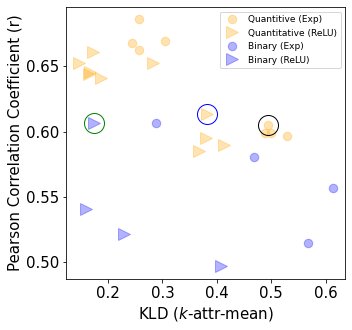

In [10]:
# ==============================================================================
# Kmer entropy results
# ==============================================================================
k1 = entropy_df

d1 = k1[k1["task_type"] == "quantitative"]
d2 = k1[k1["task_type"] == "binary"]

x1_exp = d1[d1["activation"] == "exp"].entropy.to_numpy()
y1_exp = d1[d1["activation"] == "exp"].pr_corr.to_numpy()
x1_rel = d1[d1["activation"] == "relu"].entropy.to_numpy()
y1_rel = d1[d1["activation"] == "relu"].pr_corr.to_numpy()

x2_exp = d2[d2["activation"] == "exp"].entropy.to_numpy()
y2_exp = d2[d2["activation"] == "exp"].pr_corr.to_numpy()
x2_rel = d2[d2["activation"] == "relu"].entropy.to_numpy()
y2_rel = d2[d2["activation"] == "relu"].pr_corr.to_numpy()

label_list = [
    d1[d1["activation"] == "exp"]["model"].values.tolist(),
    d1[d1["activation"] == "relu"]["model"].values.tolist(),
    d2[d2["activation"] == "exp"]["model"].values.tolist(),
    d2[d2["activation"] == "relu"]["model"].values.tolist()
]

model_labels = []
count = 0
for i in label_list:
    for j in i:

        model_labels += [j]
        count += 1
        
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)

plt.plot(x1_exp, y1_exp, '.', color="orange", markersize=17, alpha=0.3)
plt.plot(x1_rel, y1_rel, '>', color="orange", markersize=12, alpha=0.3)

plt.plot(x2_exp, y2_exp, '.', color="blue", markersize=17, alpha=0.3)
plt.plot(x2_rel, y2_rel, '>', color="blue", markersize=12, alpha=0.3)

plt.ylabel('Pearson Correlation Coefficient (r)', fontsize=15)
plt.xlabel('KLD ($\it{k}$-attr-mean)', fontsize=15)

plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=15)
plt.yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75], fontsize=15)

plt.legend(["Quantitive (Exp)", "Quantitative (ReLU)", "Binary (Exp)", "Binary (ReLU)"], fontsize=9, frameon=True, loc='upper right',) #bbox_to_anchor =(0., .0)

radius = 10
indicator_colors = ["black", "blue", "green"]
indicator_count = 0

#Circle and highlight in the plot these anecdotal examples
model_subset = [
    "binary_residual_relu",
    "cnn_base_task_relu",
    "cnn_base_all_exp",
]

count = 0
for z in ([zip(x1_exp,y1_exp), zip(x1_rel,y1_rel), zip(x2_exp, y2_exp), zip(x2_rel, y2_rel)]):

    for i, (x, y) in enumerate(z):

        idx = count

        label = model_labels[idx]

        if(label in model_subset):

            label = " ".join(label.split("_"))

            ax.plot(x, y, 'o', ms=radius * 2, mec=indicator_colors[indicator_count], mfc='none', mew=1)
            indicator_count += 1
                                                                   
        count += 1

# Plot 2D Representations

In [11]:
# Load cell line testset sequences
cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = my_args[0]
_, X, _ = utils.load_data(attr_map_path=attr_map_path, cell_line_dir=cell_line_dir)

/shared/data00/acme/acme/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  attr_map = attr_map / np.sqrt(np.sum(np.sum(np.square(attr_map), axis=-1, keepdims=True), axis=-2, keepdims=True))


In [12]:
X_rolled = np.roll(X, -1, axis=-2)
X_rolled_twice = np.roll(X, -2, axis=-2)
X_rolled_trice = np.roll(X, -3, axis=-2)
X_rolled_4 = np.roll(X, -4, axis=-2)
X_rolled_5 = np.roll(X, -5, axis=-2)
X_rolled_6 = np.roll(X, -6, axis=-2)

####################### MASKS for A, C, G, T. Thus, AAA mask would be: The whole Lx4 table of the sequence is filled with 0s, except for the positions where nucleotides are A. There, only the A-position in the 4vector is assigned the value of 1.   
AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1
        
mask1 = (np.sum(X*CCC, axis=-1)) *(np.sum(X_rolled*AAA, axis=-1)) *(np.sum(X_rolled_twice*CCC, axis=-1))*(np.sum(X_rolled_trice*GGG, axis=-1))*(np.sum(X_rolled_4*TTT, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))
mask2 = (np.sum(X*GGG, axis=-1)) *(np.sum(X_rolled*GGG, axis=-1)) *(np.sum(X_rolled_twice*GGG, axis=-1))*(np.sum(X_rolled_trice*CCC, axis=-1))*(np.sum(X_rolled_4*GGG, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))*(np.sum(X_rolled_6*GGG, axis=-1))
mask3 = (np.sum(X*GGG, axis=-1)) *(np.sum(X_rolled*CCC, axis=-1)) *(np.sum(X_rolled_twice*CCC, axis=-1))*(np.sum(X_rolled_trice*AAA, axis=-1))*(np.sum(X_rolled_4*TTT, axis=-1))

for i in range(0,len(my_args)):
    print(i , my_args[i][-1])

# good: index: 24 , "cnn_base_all_exp"
# medium: index: 12  , "cnn_base_task_relu"
# bad: index: 1 , "binary_residual_relu"

0 /shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_basset_relu
1 /shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_residual_relu
2 /shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_cnn_relu
3 /shared/data00/acme/results/atac/method_2/GM12878/binary/relu/binary_basenji_relu
4 /shared/data00/acme/results/atac/method_2/GM12878/binary/exp/binary_cnn_exp
5 /shared/data00/acme/results/atac/method_2/GM12878/binary/exp/binary_basenji_exp
6 /shared/data00/acme/results/atac/method_2/GM12878/binary/exp/binary_basset_exp
7 /shared/data00/acme/results/atac/method_2/GM12878/binary/exp/binary_residual_exp
8 /shared/data00/acme/results/atac/method_2/GM12878/quantitative/relu/cnn_32_all_relu
9 /shared/data00/acme/results/atac/method_2/GM12878/quantitative/relu/cnn_32_task_relu
10 /shared/data00/acme/results/atac/method_2/GM12878/quantitative/relu/cnn_base_all_relu
11 /shared/data00/acme/results/atac/method_2/GM12878/quantitative/relu/bpnet
12 /s

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/exp/cnn_base_all_exp.pickle


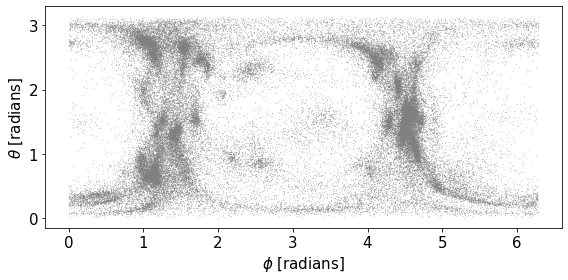

In [14]:
# Model good (24)
arg = my_args[24]

cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = arg
print(attr_map_path)

attribution_map, X, y = utils.load_data(attr_map_path=attr_map_path, cell_line_dir=cell_line_dir, gradient_correct=False, normalize=False)
radius_count_cutoff=0.01
box_length=0.1
attribution_map = process_attribution_map(attribution_map)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.1,  c='gray', alpha=0.8, rasterized=True)

plt.xlabel(r"${\phi}$ [radians]")
plt.ylabel(r"${\theta}$ [radians]")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.yticks(([0,1,2,3]),fontsize=15)
plt.xticks(fontsize=15)
fig.tight_layout()

/shared/data00/acme/data/atac/saliency_subset/GM12878/quantitative/relu/cnn_base_task_relu.pickle


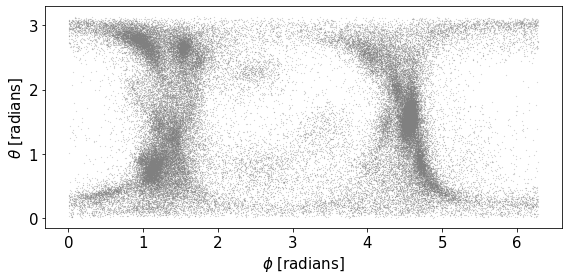

In [15]:
# Model medium (12)
arg = my_args[12]

cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = arg
print(attr_map_path)

attribution_map, X, y = utils.load_data(attr_map_path=attr_map_path, cell_line_dir=cell_line_dir, gradient_correct=False, normalize=False)
radius_count_cutoff=0.01
box_length=0.1
attribution_map = process_attribution_map(attribution_map)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.1,  c='gray', alpha=0.8, rasterized=True)

plt.xlabel(r"${\phi}$ [radians]")
plt.ylabel(r"${\theta}$ [radians]")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.yticks(([0,1,2,3]),fontsize=15)
plt.xticks(fontsize=15)
fig.tight_layout()

/shared/data00/acme/data/atac/saliency_subset/GM12878/binary/relu/binary_residual_relu.pickle


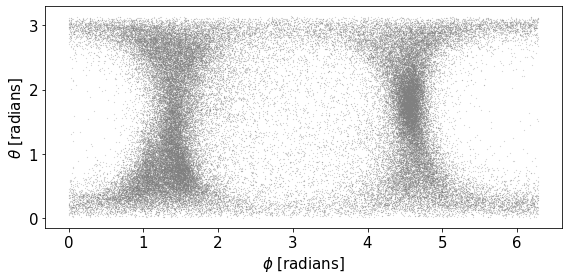

In [16]:
# Model bad (1)
arg = my_args[1]

cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = arg
print(attr_map_path)

attribution_map, X, y = utils.load_data(attr_map_path=attr_map_path, cell_line_dir=cell_line_dir, gradient_correct=False, normalize=False)
radius_count_cutoff=0.01
box_length=0.1
attribution_map = process_attribution_map(attribution_map)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.1,  c='gray', alpha=0.8, rasterized=True)

plt.xlabel(r"${\phi}$ [radians]")
plt.ylabel(r"${\theta}$ [radians]")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.yticks(([0,1,2,3]),fontsize=15)
plt.xticks(fontsize=15)
fig.tight_layout()

# Synthetic

In [18]:
def my_func_entropy_synthetic(model_and_attr_map):
    
    data = {
        "entropy": [],
        "auroc": [],
        "snr": [],
        "lr_type": [],
        "bn": [],
        "activation": [],
        "method": [],
        "trial": [],
        "path": [],
    }

    lr_type, bn, activation, method, attr_type, trial, out_path, path, attribution_map, auroc, snr = model_and_attr_map

    data["path"] += [path]
    
    _, _, _, X, X_model = utils.get_dataset(filepath=synthetic_code_path)
  
    radius_count_cutoff = 0.99
    box_length = 0.1
    attribution_map = process_attribution_map(attribution_map)
    unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
    
    phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
    LIM, box_length, box_volume, n_bins, n_bins_half = initialize_integration_2(box_length)
    entropic_information = calculate_entropy_2(phi_1_s, phi_2_s, r_s, n_bins, box_length, box_volume, prior_range = 3)

    data["entropy"] += [entropic_information[0]]
    data["auroc"] += [auroc]
    data["lr_type"] += [lr_type]
    data["activation"] += [activation]
    data["method"] += [method]
    data["trial"] += [trial]
    data["bn"] += [bn]
    data["snr"] += [snr]
    
    pd.DataFrame(data).to_csv(f"{out_path}/entropy_results.csv", index=None)

    return

In [21]:
# Create list of arguments to pass through function
out_dir = BASE_DIR.joinpath("results/synthetic/method_2")
synthetic_path = BASE_DIR.joinpath("data/synthetic/synthetic_data.h5")

synthetic_args = []

with h5py.File(synthetic_path, 'r') as f:
    
    for grp_name in f.keys():
        
        attr_map = f[grp_name]["attr_map"][:]
        auroc = f[grp_name]["auroc"][()]
        snr = f[grp_name]["snr"][()]
        path = f[grp_name]["path"][()].decode('UTF-8')

        lr_type, bn, activation, method, attr_type, trial = path.split('/')[1:]
        trial = int(trial)
        out_path = f"{out_dir}{path}"
        Path(f"{out_path}").mkdir(parents=True, exist_ok=True)
        
        synthetic_args += [(lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr)]

In [22]:
# Test for a single argument
my_func_entropy_synthetic(synthetic_args[0])

/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
# Run for all args
utils.run_pool(my_func_entropy_synthetic, synthetic_args, 20)

Running function using 20 workers


  0%|                                                                                                        | 0/327 [00:00<?, ?it/s]/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
  6%|█████▊                                                                                         | 20/327 [00:07<00:46,  6.66it/s]/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encounte

/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
 12%|███████████                                                                                    | 38/327 [00:13<01:01,  4.72it/s]/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divi

# Evaluate

In [24]:
data = []
for arg in synthetic_args:
    lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr = arg

    frame = pd.read_csv(f"{out_path}/entropy_results.csv")

    data += [frame]

entropy_df = pd.concat(data, axis=0)    
entropy_df["index"] = range(len(entropy_df))
entropy_df

,entropy,auroc,snr,lr_type,bn,activation,method,trial,path,index
0,0.434,0.973462,1.315170,fixedlr,bn,exponential,adversarial,1,/fixedlr/bn/exponential/adversarial/saliency/1,0
0,0.428,0.971930,1.570055,fixedlr,bn,exponential,adversarial,10,/fixedlr/bn/exponential/adversarial/saliency/10,1
0,1.064,0.978952,6.810561,fixedlr,bn,exponential,gn,0,/fixedlr/bn/exponential/gn/saliency/0,2
0,0.203,0.978991,1.797297,fixedlr,bn,relu,manifold-gn,2,/fixedlr/bn/relu/manifold-gn/saliency/2,3
0,0.218,0.984649,0.140598,fixedlr,bn,relu,manifold-gn,3,/fixedlr/bn/relu/manifold-gn/saliency/3,4
...,...,...,...,...,...,...,...,...,...,...
0,0.145,0.974185,0.535987,fixedlr,bn,relu,gn,7,/fixedlr/bn/relu/gn/saliency/7,322
0,0.136,0.975217,0.397261,fixedlr,bn,relu,gn,8,/fixedlr/bn/relu/gn/saliency/8,323
0,0.167,0.976608,0.471243,fixedlr,bn,relu,gn,9,/fixedlr/bn/relu/gn/saliency/9,324
0,0.245,0.976566,1.755213,fixedlr,bn,relu,manifold-gn,0,/fixedlr/bn/relu/manifold-gn/saliency/0,325


In [25]:
# identify indices of subselected models
lower_bound = "/fixedlr/nobn/relu/gn/saliency/12"
upper_bound = "/fixedlr/bn/exponential/manifold-mixup/saliency/2"
sub_models = [lower_bound, upper_bound]
entropy_df[entropy_df["path"].isin(sub_models)]

,entropy,auroc,snr,lr_type,bn,activation,method,trial,path,index
0,0.138,0.98590,0.568456,fixedlr,nobn,relu,gn,12,/fixedlr/nobn/relu/gn/saliency/12,166
0,0.869,0.98666,4.142531,fixedlr,bn,exponential,manifold-mixup,2,/fixedlr/bn/exponential/manifold-mixup/saliency/2,266


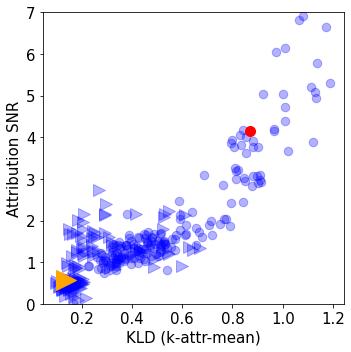

In [26]:
# Plot scatterplots
REGULARIZERS = [
    'standard',
    'mixup',
    'manifold-mixup',
    'gn',
    'manifold-gn',
    'sn',
    'adversarial',
]

reg_dict = {
    'standard': "Standard",
    'mixup': "Mixup",
    'manifold-mixup': "Manifold-mixup",
    'gn': "Noise",
    'manifold-gn': "Manifold-noise",
    'sn': "Spectral-norm",
    'adversarial': "Adversarial",
}

ACTIVATIONS = ['relu','exponential']
BN = ['bn', 'nobn']
SCHEDULE = ['fixedlr'] 

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)

for k, lr_type in enumerate(SCHEDULE):

    res = entropy_df[entropy_df["lr_type"] == lr_type]

    for i, regularizer in enumerate(REGULARIZERS):

        r1 = res[res["method"] == regularizer]

        for j, bn in enumerate(BN):

            d1 = r1[r1["bn"] == bn]

            x1_exp = d1[d1["activation"] == "exponential"].entropy.to_numpy()
            y1_exp = d1[d1["activation"] == "exponential"].snr.to_numpy()
            x1_rel = d1[d1["activation"] == "relu"].entropy.to_numpy()
            y1_rel = d1[d1["activation"] == "relu"].snr.to_numpy()
                       
            if ((k == 0) and (j == 0)):
                label = reg_dict[regularizer]
            else:
                label = None

            plt.plot(x1_exp, y1_exp, '.', color="blue", label=None, markersize=17, alpha=0.3)
            plt.plot(x1_rel, y1_rel, '>', color="blue", label=None, markersize=12, alpha=0.3)
            
x = entropy_df[entropy_df["index"] == 266].entropy.to_numpy()
y = entropy_df[entropy_df["index"] == 266].snr.to_numpy()
plt.plot(x, y, '.', color="red", label=None, markersize=20, alpha=1) #alpha=0.5

x = entropy_df[entropy_df["index"] == 166].entropy.to_numpy()
y = entropy_df[entropy_df["index"] == 166].snr.to_numpy()
plt.plot(x, y, '>', color="orange", label=None, markersize=20, alpha=1) #alpha=0.5

ax.set_xlabel("KLD (k-attr-mean)", fontsize=15)
ax.set_ylabel("Attribution SNR", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 7)
plt.tight_layout();

plt.show()

In [27]:
pearsonr(entropy_df["snr"].to_numpy(), entropy_df["entropy"].to_numpy())

(0.8746502622044673, 3.147907576663901e-104)

# Plot 2D representations

In [28]:
# Create list of arguments to pass through function
out_dir = BASE_DIR.joinpath("results/synthetic/method_2")
synthetic_path = BASE_DIR.joinpath("data/synthetic/synthetic_data.h5")

attr_map_path_1 = "/fixedlr/bn/exponential/manifold-mixup/saliency/2"
attr_map_path_2 = "/fixedlr/nobn/relu/gn/saliency/12"

with h5py.File(synthetic_path, 'r') as f:
    
    for grp_name in f.keys():    
        
        attr_map = f[grp_name]["attr_map"][:]
        auroc = f[grp_name]["auroc"][()]
        snr = f[grp_name]["snr"][()]
        path = f[grp_name]["path"][()].decode('UTF-8')
        if(path in [attr_map_path_1, attr_map_path_2]):
            print(grp_name, path)

248 /fixedlr/nobn/relu/gn/saliency/12
44 /fixedlr/bn/exponential/manifold-mixup/saliency/2


In [29]:
with h5py.File(synthetic_path, 'r') as f:

    attr_map_1 = f["44"]["attr_map"][:]
    attr_map_2 = f["248"]["attr_map"][:]

# Load testset data and ground truth
_, _, _, X, X_model = utils.get_dataset(filepath=synthetic_code_path)

X_model = X_model - 0.25

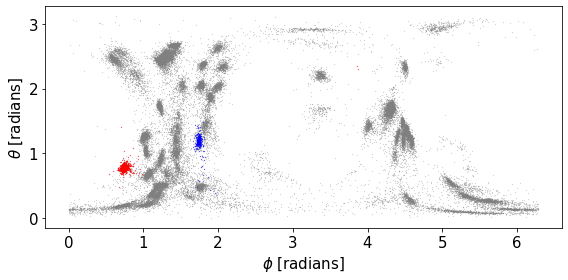

In [30]:
# calculate interpretability
radius_count_cutoff = 0.10
box_length = 0.10
attribution_map = process_attribution_map(attr_map_1)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
LIM, box_length, box_volume, n_bins, n_bins_half = initialize_integration_2(box_length)
entropic_information = calculate_entropy_2(phi_1_s, phi_2_s, r_s, prior_range=3, n_bins=n_bins, box_volume=box_volume, box_length=box_length, )

# now you can plot the coordinates
X_rolled = np.roll(X, -1, axis=-2)
X_rolled_twice = np.roll(X, -2, axis=-2)
X_rolled_trice = np.roll(X, -3, axis=-2)
X_rolled_4 = np.roll(X, -4, axis=-2)
X_rolled_5 = np.roll(X, -5, axis=-2)
X_rolled_6 = np.roll(X, -6, axis=-2)

####################### MASKS for A, C, G, T. Thus, AAA mask would be: The whole Lx4 table of the sequence is filled with 0s, except for the positions where nucleotides are A. There, only the A-position in the 4vector is assigned the value of 1.   
AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1
        
#Color some motifs! 
mask1 = (np.sum(X*CCC, axis=-1)) *(np.sum(X_rolled*AAA, axis=-1)) *(np.sum(X_rolled_twice*CCC, axis=-1))*(np.sum(X_rolled_trice*GGG, axis=-1))*(np.sum(X_rolled_4*TTT, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))
mask2 = (np.sum(X*CCC, axis=-1)) *(np.sum(X_rolled*GGG, axis=-1)) *(np.sum(X_rolled_twice*GGG, axis=-1))*(np.sum(X_rolled_trice*AAA, axis=-1))*(np.sum(X_rolled_4*AAA, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.1,  c='gray', alpha=0.8, rasterized=True)

# Mask1
phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, mask1, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.2,  c='red', alpha=0.99, rasterized=True)

# Mask2
phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, mask2, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.2,  c='blue', alpha=0.99, rasterized=True)

# Set title
title = " ".join(path.split("/"))
plt.xlabel(r"${\phi}$ [radians]")
plt.ylabel(r"${\theta}$ [radians]")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.yticks(([0,1,2,3]),fontsize=15)
plt.xticks(fontsize=15)
fig.tight_layout()

/home/chandana/anaconda3/envs/scbasset/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


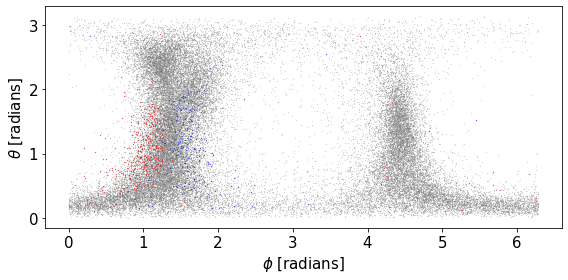

In [31]:
# calculate interpretability
radius_count_cutoff = 0.10
box_length = 0.10
attribution_map = process_attribution_map(attr_map_2)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
LIM, box_length, box_volume, n_bins, n_bins_half = initialize_integration_2(box_length)
entropic_information = calculate_entropy_2(phi_1_s, phi_2_s, r_s, prior_range=3, n_bins=n_bins, box_volume=box_volume, box_length=box_length, )

# now you can plot the coordinates
X_rolled = np.roll(X, -1, axis=-2)
X_rolled_twice = np.roll(X, -2, axis=-2)
X_rolled_trice = np.roll(X, -3, axis=-2)
X_rolled_4 = np.roll(X, -4, axis=-2)
X_rolled_5 = np.roll(X, -5, axis=-2)
X_rolled_6 = np.roll(X, -6, axis=-2)

####################### MASKS for A, C, G, T. Thus, AAA mask would be: The whole Lx4 table of the sequence is filled with 0s, except for the positions where nucleotides are A. There, only the A-position in the 4vector is assigned the value of 1.   
AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
unit_mask = np.sum(np.ones(X.shape),axis=-1)/4
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1
        
# Color some motifs! 
mask1 = (np.sum(X*CCC, axis=-1)) *(np.sum(X_rolled*AAA, axis=-1)) *(np.sum(X_rolled_twice*CCC, axis=-1))*(np.sum(X_rolled_trice*GGG, axis=-1))*(np.sum(X_rolled_4*TTT, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))
mask2 = (np.sum(X*CCC, axis=-1)) *(np.sum(X_rolled*GGG, axis=-1)) *(np.sum(X_rolled_twice*GGG, axis=-1))*(np.sum(X_rolled_trice*AAA, axis=-1))*(np.sum(X_rolled_4*AAA, axis=-1))*(np.sum(X_rolled_5*GGG, axis=-1))

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.1,  c='gray', alpha=0.8, rasterized=True)

# Mask1
phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, mask1, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.2,  c='red', alpha=0.99, rasterized=True)

# Mask2
phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, mask2, radius_count_cutoff)
plt.scatter(np.array(phi_1_s[0])*2, np.array(phi_2_s[0]), marker='.', s=0.2,  c='blue', alpha=0.99, rasterized=True)

# Set title
title = " ".join(path.split("/"))
plt.xlabel(r"${\phi}$ [radians]")
plt.ylabel(r"${\theta}$ [radians]")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.yticks(([0,1,2,3]),fontsize=15)
plt.xticks(fontsize=15)
fig.tight_layout()       